# Single Model Monetization - Part 2
### CSCI 4210 - Simulation and Modeling
#### Matthew Wicker

In this notebook, we will reload our pretrained model. Then, we will attempt to exploit this models prediction to maximize profits (or to minimize losses!).
### Getting started - Clone the DeepMarketModels Repository:

#### • From your terminal run the following command: git clone https://github.com/matthewwicker/DeepMarketModels.git
 

In [1]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

import csv
import numpy as np
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 10)
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os


#===========================================================
#          We have set these for reproducibility
#===========================================================

np.random.seed(5)
look_back = 7

#===========================================================
#      Constants which define the stock you want to use
#===========================================================

# Here is the path to your finacial data from Yahoo:
# Note: Replace NVIDIA stock. Not enough data on recent trends
STOCK_TO_USE = "V"
DATA_PATH = "FinData/" + STOCK_TO_USE + ".csv"
MODEL_JSON_PATH = "FinModels/" + STOCK_TO_USE + ".json"
MODEL_WEIGHT_PATH = "FinModels/" + STOCK_TO_USE + ".h5"

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load in the data that we will be using

This is the same as in the previous notebook

In [2]:
# Here are the basic values of each stock that we have information on
class date:
    def __init__(self):
        self.date = "NaN"
        self.open = 0.0
        self.high = 0.0
        self.low = 0.0
        self.close = 0.0
        self.adj = 0.0
        self.volume = 0.0
    def reinit(self, date, op, high, low, close, adj, vol):
        self.date = date
        self.open = float(op)
        self.high = float(high)
        self.low = float(low)
        self.close = float(close)
        self.adj = float(adj)
        self.volume = float(vol)
        
data_entries = []
print ("Opening File: %s"%(DATA_PATH))
with open(DATA_PATH, 'rb') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if('null' in row): continue;
        if(i == 0): continue;
        temp_date = date()
        temp_date.reinit(row[0], row[1], row[2], row[3], row[4], row[5], row[6])
        data_entries.append(temp_date)
        
dates_of_data = np.asarray([i.date for i in data_entries])
open_of_data = np.asarray([i.open for i in data_entries])
close_of_data = np.asarray([i.close for i in data_entries])
high_of_data = np.asarray([i.high for i in data_entries])
low_of_data = np.asarray([i.low for i in data_entries])

dates_of_data = dates_of_data[-2500:]
open_of_data = open_of_data[-2500:]
close_of_data = close_of_data[-2500:]
high_of_data = high_of_data[-2500:]
low_of_data = low_of_data[-2500:]


print("Done reading file")

Opening File: FinData/V.csv
Done reading file


## Load in the pre-trained model

In [3]:
layers = [1,look_back,1]
model = Sequential()
d = 0.1
model = Sequential()    
model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=False))
model.add(Dropout(d))
        
model.add(Dense(4,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

model.load_weights(MODEL_WEIGHT_PATH)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 4,489
Trainable params: 4,489
Non-trainable params: 0
_________________________________________________________________


## Test - Train Split (just as before)

In [4]:
stock_prices = open_of_data
stock_prices = stock_prices.reshape(len(stock_prices), 1)


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(stock_prices)

train_size = int(len(stock_prices) * 0.95)
test_size = len(stock_prices) - train_size
train, test = stock_prices[0:train_size,:], stock_prices[train_size:len(stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# convert stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


# Here is where some things are different: 
testX_E = testX[:100]
testX_P = testX[:-25]


print("Done with split")

Split data into training set and test set... Number of training samples/ test samples: 2260 119
Done with split


## Create a relevent measure of our data based on some unseen data

In [5]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainY = trainY.reshape(len(trainY[0]), 1)
testY = testY.reshape(len(testY[0]), 1)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(stock_prices)-1, :] = testPredict

Train Score: 1.11 RMSE
Test Score: 1.17 RMSE


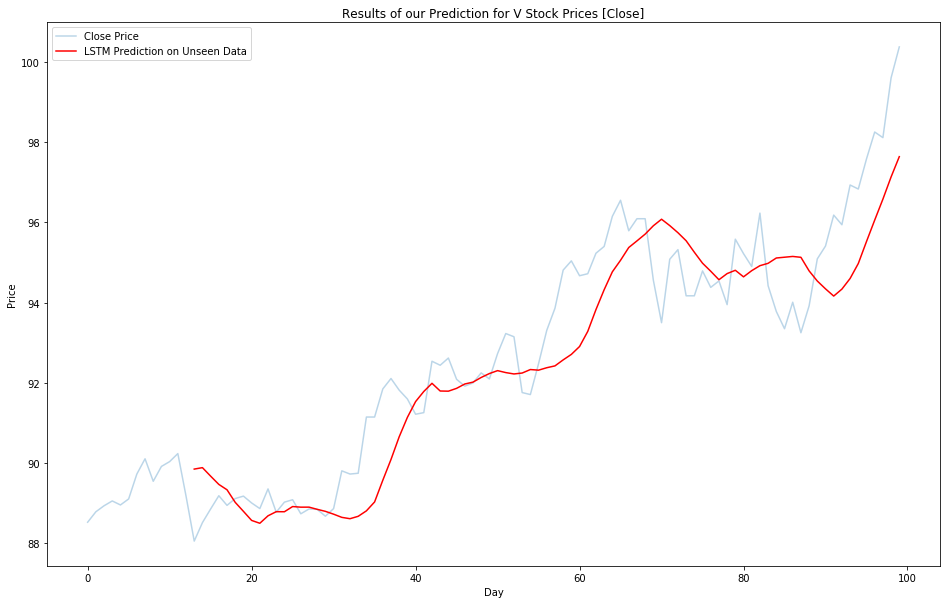

In [6]:
# plot baseline and predictions
plt.clf()
plt.title("Results of our Prediction for %s Stock Prices [Close]"%(STOCK_TO_USE))
plt.xlabel("Day")
plt.ylabel("Price")
test_size = 125

real = close_of_data[-test_size:]
pred = testPredictPlot[-test_size:]

c, = plt.plot(real[:100], label='Close Price',alpha=0.3)
predict_test, = plt.plot(pred[:100], label='LSTM Prediction on Unseen Data', color='r')
plt.legend(handles=[c, predict_test])
plt.show()

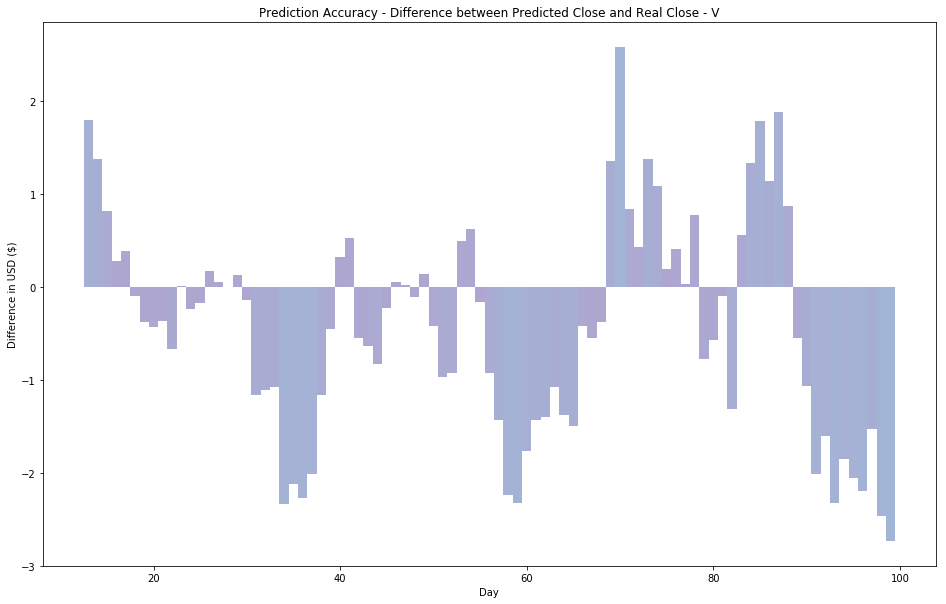

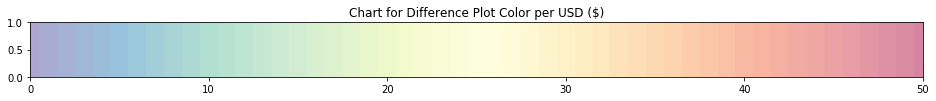

In [7]:
#objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
cod = real[:100]
lstmp = pred[:100]
performance = [lstmp[i] - cod[i] for i in range(100)]
y_pos = np.arange(len(performance))

cmap = matplotlib.cm.get_cmap('Spectral_r')
max_val = 50
colors = []
for i in performance:
    color_val = cmap(abs(i)/max_val)
    hex_col = '#%02x%02x%02x' % (color_val[0][0]*255, color_val[0][1]*255, color_val[0][2]*255)
    colors.append(hex_col)


    
plt.bar(y_pos, performance, align='center', alpha=0.5,width=1.0, color=colors)
plt.ylabel('Difference in USD ($)')
plt.title('Prediction Accuracy - Difference between Predicted Close and Real Close - %s'%(STOCK_TO_USE))
plt.xlabel('Day')

plt.show()

max_val += 1
pylab.rcParams['figure.figsize'] = (16, 1)
plt.clf()
ones = np.ones(max_val)
color_val = [cmap(float(i)/max_val)for i in range(max_val)]
plt.bar(np.arange(max_val), ones, align='center', alpha=0.5,width=1.0, color=color_val)
plt.ylim([0,1])
plt.xlim([0,50])
plt.title("Chart for Difference Plot Color per USD ($)")
plt.show()
pylab.rcParams['figure.figsize'] = (16, 10)

# Turning the visuals into something useful:

Number of overshoots: 33 Average Overshoot Val: 0.720146660911
Number of undershoots: 54 Average Undershoot Val: -1.13077150991


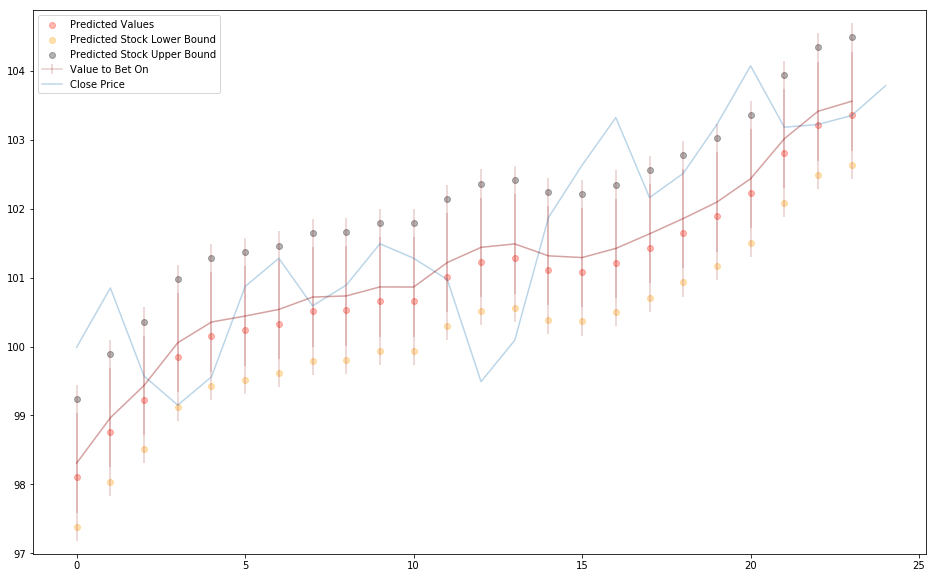

In [8]:
# First lets seperate the negative values from the 
# positive values so we can get a sense of if we 
# are over predicting or under predicting
cmap = matplotlib.cm.get_cmap('hot_r')
cod = real[:100]
lstmp = pred[:100]

negs = [lstmp[i] - cod[i] for i in range(100) if((lstmp[i] - cod[i]) < 0)]
poss = [lstmp[i] - cod[i] for i in range(100) if((lstmp[i] - cod[i]) > 0)]

negs = np.asarray(negs)
poss = np.asarray(poss)

print("Number of overshoots: %s Average Overshoot Val: %s"%(len(poss), np.average(poss)))
print("Number of undershoots: %s Average Undershoot Val: %s"%(len(negs), np.average(negs)))
# After getting the trend of over or under predicting
# we will figure out the average overshoot and 
# undershoot

real = close_of_data[-test_size:]
pred = testPredictPlot[-test_size:]

overshoot =  np.average(poss)
undershoot =  np.average(negs)
naive_bet = (overshoot+undershoot)/2

x_vals = np.arange(25)

pred_ub = [i-overshoot for i in pred[-25:]]
pred_lb = [i-undershoot for i in pred[-25:]]
pred_b = [i-naive_bet for i in pred[-25:]]
r = plt.scatter(x_vals, pred[-25:], label="Predicted Values", alpha=0.3, color=cmap(0.6))
l = plt.scatter(x_vals, pred_ub, label="Predicted Stock Lower Bound", alpha=0.3, color=cmap(0.4))
u = plt.scatter(x_vals, pred_lb, label="Predicted Stock Upper Bound", alpha=0.3, color=cmap(1.0))
b = plt.errorbar(x_vals, pred_b, yerr=overshoot, label="Value to Bet On", alpha=0.2, color=cmap(0.8))
b = plt.errorbar(x_vals, pred_b, yerr=undershoot, label="Value to Bet On", alpha=0.2, color=cmap(0.8))
o, = plt.plot(real[-25:], label='Close Price',alpha=0.3)
plt.legend(handles=[r,l,u,b,o])
plt.show()

## Using under and overshoot to maximize profits

In [9]:
# First thing we will do is establish our 
# initial funds : $10,000

# Given the current price and the prediction for
# the next day we will buy or sell

# We shouldn't just take the prediction as truth,
# we should compensate for the possibility of over
# or undershoot in our prediction

